# Paddy with resnet18

I think resnet18 should work fine. Let's see how far we can go with resnet18.

In [1]:
from fastai.vision.all import *

In [2]:
path = Path('.')
trn_path = path/'train_images'
im = PILImage.create((trn_path/'bacterial_leaf_blight'/'110320.jpg'))
print(im.size)

(192, 256)


In [3]:
480 / 640, 192 / 256

(0.75, 0.75)

In [4]:
arch = resnet18

## Batch size difference

In [12]:
def train(arch, epochs=5, item=Resize(224, method='squish'), batch=aug_transforms(size=128), bs=64):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch, bs=bs)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [8]:
learn = train(arch, epochs=20, bs=512)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.588730,1.553502,0.444978,00:30


epoch,train_loss,valid_loss,error_rate,time
0,1.400828,0.854774,0.266699,00:29
1,1.099445,0.586264,0.190293,00:29
2,0.865046,0.398356,0.125901,00:29
3,0.672969,0.306494,0.090822,00:29
4,0.534137,0.303736,0.089380,00:29
5,0.427832,0.253077,0.071600,00:29
6,0.344374,0.294932,0.074483,00:28
7,0.282158,0.243492,0.067275,00:29
8,0.231893,0.261544,0.059106,00:29
9,0.195217,0.235404,0.058626,00:28


In [9]:
# Smaller batch size
learn = train(arch, epochs=20, bs=128)

epoch,train_loss,valid_loss,error_rate,time
0,2.111028,1.310498,0.417588,00:23


epoch,train_loss,valid_loss,error_rate,time
0,1.026113,0.588358,0.189332,00:27
1,0.654387,0.364322,0.117732,00:27
2,0.443580,0.352165,0.101874,00:27
3,0.390577,0.387680,0.110043,00:27
4,0.338199,0.340303,0.091783,00:27
5,0.289709,0.292676,0.074964,00:26
6,0.246151,0.291145,0.083614,00:27
7,0.223666,0.270396,0.073042,00:27
8,0.183332,0.256110,0.063431,00:27
9,0.152992,0.217779,0.047573,00:27


In [10]:
learn = train(arch, epochs=20, bs=64)

epoch,train_loss,valid_loss,error_rate,time
0,1.957186,1.358017,0.429601,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.910006,0.566050,0.167227,00:25
1,0.569418,0.383496,0.120135,00:25
2,0.461830,0.346936,0.103796,00:26
3,0.454056,0.452544,0.126862,00:26
4,0.390405,0.378692,0.102355,00:25
5,0.358672,0.418734,0.113888,00:26
6,0.336793,0.284078,0.081211,00:26
7,0.274452,0.489478,0.124940,00:26
8,0.224228,0.263614,0.066795,00:26
9,0.181117,0.201464,0.052859,00:26


In [11]:
learn = train(arch, epochs=20, bs=32)

epoch,train_loss,valid_loss,error_rate,time
0,1.952353,1.372187,0.433445,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.887642,0.520324,0.166266,00:32
1,0.585906,0.468536,0.139837,00:32
2,0.552951,0.374937,0.118693,00:32
3,0.594669,0.405484,0.126382,00:32
4,0.498871,0.482782,0.144161,00:32
5,0.467337,0.389190,0.120135,00:32
6,0.397164,0.362029,0.095627,00:32
7,0.309164,0.280873,0.078328,00:32
8,0.266781,0.277738,0.077367,00:32
9,0.227106,0.243263,0.068236,00:32


It's interesting that bigger batch size performed worse. I thought bigger batch size would always be better. 

Is it always the case regardless of what learning rate we use? Let's try what happens.

## Learning rate difference

In [13]:
def get_learn(arch, item=Resize(224, method='squish'), batch=aug_transforms(size=128), bs=64):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch, bs=bs)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.lr_find()
    return learn

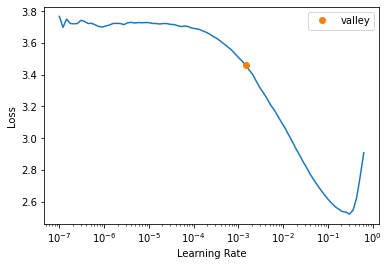

In [15]:
learn = get_learn(arch, bs=512)

It's 0.01, which we used. What if we use 0.001?

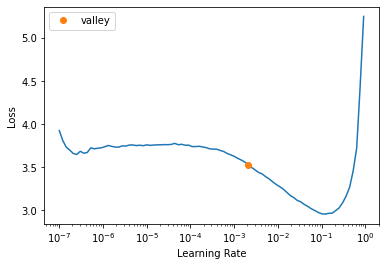

In [16]:
learn = train(arch, bs=128)

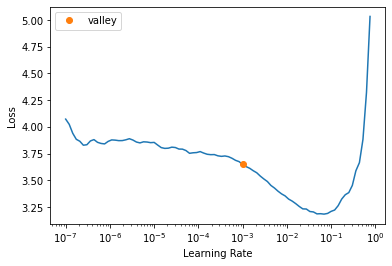

In [17]:
learn = train(arch, bs=64)

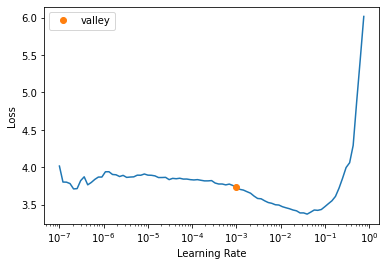

In [18]:
learn = train(arch, bs=32)

Well, it trained quickly, but it was not very great. It is still great base case. We can apply multitask and see what we get.

## TTA!

In [23]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [24]:
error_rate(preds, targs)

TensorBase(0.0985)

Using tta:

In [33]:
tta_preds, _ = learn.tta(dl=valid)

In [34]:
error_rate(tta_preds, targs)

TensorBase(0.0759)

Using tta with use_max may be better:

In [31]:
tta_preds, _ = learn.tta(dl=valid, use_max=True)

In [32]:
error_rate(tta_preds, targs)

TensorBase(0.0827)

Didn't really work out this time..

## Submission

- Grab the test items.
- Use learn.tta to get predictions. 
- Turn predictions(index) into strings.

In [40]:
tst_path = get_image_files(path/'test_images/')
tst_path

(#3469) [Path('test_images/200770.jpg'),Path('test_images/203307.jpg'),Path('test_images/203265.jpg'),Path('test_images/201796.jpg'),Path('test_images/202973.jpg'),Path('test_images/201780.jpg'),Path('test_images/201052.jpg'),Path('test_images/201179.jpg'),Path('test_images/201783.jpg'),Path('test_images/200080.jpg')...]

Test items should be in the same order as submission, so we sort the tst_path.

In [38]:
# submission has different order from tst_path
ss = pd.read_csv('sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [41]:
tst_path.sort()
tst_path

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

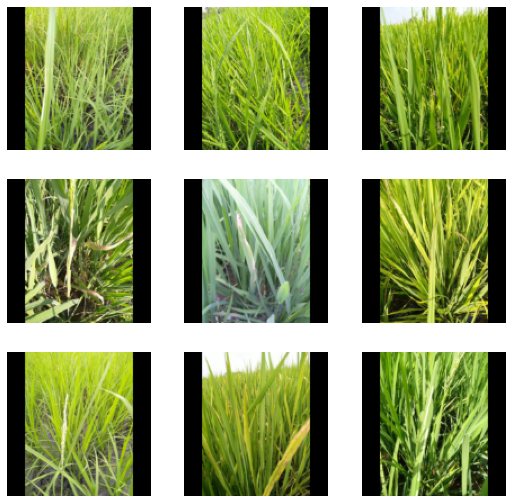

In [44]:
tst_dl = learn.dls.test_dl(tst_path)
tst_dl.show_batch()

In [45]:
preds, _ = learn.tta(dl=tst_dl)

In [49]:
idxs = preds.argmax(dim=1)
idxs

TensorBase([7, 8, 6,  ..., 8, 1, 5])

In [52]:
vocab = learn.dls.vocab
vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [54]:
results = pd.Series(vocab[idxs], name='idxs')
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [57]:
ss['label'] = results
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,downy_mildew
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [60]:
ss.to_csv('subm_res26d_5ep_tta.csv', index=False)

In [61]:
!head subm_res26d_5ep_tta.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
